In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve 
from sklearn.metrics import roc_auc_score, roc_curve, det_curve, jaccard_score, class_likelihood_ratios 
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import kstest, ks_2samp
from matplotlib.ticker import FuncFormatter
import chardet    
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')

path = 'https://raw.githubusercontent.com/ozim-ml/ozim-cr/main/train.csv'

df = pd.read_csv(path, sep=',', index_col='Id', encoding=file_encoding)

def replace_and_remove(value):
    if isinstance(value, str):
        return value.replace(' ', '_').replace('(', '').replace(')', '').replace('.', '')
    else:
        return value

df = df.applymap(replace_and_remove)

df.columns = ['_'.join(col.split(' ')).lower() for col in df.columns]

df = df.rename({'credit_default': 'target'}, axis=1)

df[:1]

,home_ownership,annual_income,years_in_current_job,tax_liens,number_of_open_accounts,years_of_credit_history,maximum_open_credit,number_of_credit_problems,months_since_last_delinquent,bankruptcies,purpose,term,current_loan_amount,current_credit_balance,monthly_debt,credit_score,target
Id,,,,,,,,,,,,,,,,,
0,Own_Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt_consolidation,Short_Term,99999999.0,47386.0,7914.0,749.0,0


In [220]:
# percentage value count of target variable
round(1e2 * df['target'].value_counts()/len(df), 2)

target
0    71.83
1    28.17
Name: count, dtype: float64

In [221]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   home_ownership                7500 non-null   object 
 1   annual_income                 5943 non-null   float64
 2   years_in_current_job          7129 non-null   object 
 3   tax_liens                     7500 non-null   float64
 4   number_of_open_accounts       7500 non-null   float64
 5   years_of_credit_history       7500 non-null   float64
 6   maximum_open_credit           7500 non-null   float64
 7   number_of_credit_problems     7500 non-null   float64
 8   months_since_last_delinquent  3419 non-null   float64
 9   bankruptcies                  7486 non-null   float64
 10  purpose                       7500 non-null   object 
 11  term                          7500 non-null   object 
 12  current_loan_amount           7500 non-null   float64
 13  current_

In [222]:
if df.isnull().sum().sum() != 0:
    na_df = (df.isnull().sum() / len(df)) * 100
    na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
na_df.round(2)

months_since_last_delinquent    54.41
annual_income                   20.76
credit_score                    20.76
years_in_current_job             4.95
bankruptcies                     0.19
dtype: float64

In [223]:
for column in df.columns:
    if df[column].dtype == 'object':
        df[column].fillna('None', inplace=True)
    else:
        df[column].fillna(0, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   home_ownership                7500 non-null   object 
 1   annual_income                 7500 non-null   float64
 2   years_in_current_job          7500 non-null   object 
 3   tax_liens                     7500 non-null   float64
 4   number_of_open_accounts       7500 non-null   float64
 5   years_of_credit_history       7500 non-null   float64
 6   maximum_open_credit           7500 non-null   float64
 7   number_of_credit_problems     7500 non-null   float64
 8   months_since_last_delinquent  7500 non-null   float64
 9   bankruptcies                  7500 non-null   float64
 10  purpose                       7500 non-null   object 
 11  term                          7500 non-null   object 
 12  current_loan_amount           7500 non-null   float64
 13  current_

In [224]:
df.years_in_current_job.value_counts()

years_in_current_job
10+_years    2332
2_years       705
3_years       620
<_1_year      563
5_years       516
1_year        504
4_years       469
6_years       426
7_years       396
None          371
8_years       339
9_years       259
Name: count, dtype: int64

In [225]:
encoding = {'10+_years': 10,
            '2_years': 2,    
            '3_years': 3,   
            '<_1_year': 0,   
            '5_years': 5,   
            '1_year': 1,     
            '4_years': 4,     
            '6_years': 6,     
            '7_years': 7,     
            'None': -1,       
            '8_years': 8,     
            '9_years': 9,
           }

df.years_in_current_job = df.years_in_current_job.map(encoding)
df.years_in_current_job

Id
0       -1
1       10
2        8
3        6
4        8
        ..
7495     0
7496     1
7497     6
7498    -1
7499     4
Name: years_in_current_job, Length: 7500, dtype: int64

In [226]:
# Transforming values of object columns to numeric 

num_df = df.copy()

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OrdinalEncoder
mms = MinMaxScaler()
sts = StandardScaler()
rbs = RobustScaler()
ord = OrdinalEncoder().set_output(transform="pandas")

for column in num_df.columns:
    if num_df[column].dtype.name == 'object':
        num_df[column] = ord.fit_transform(num_df[[column]]).astype('int64')

num_df.head()

,home_ownership,annual_income,years_in_current_job,tax_liens,number_of_open_accounts,years_of_credit_history,maximum_open_credit,number_of_credit_problems,months_since_last_delinquent,bankruptcies,purpose,term,current_loan_amount,current_credit_balance,monthly_debt,credit_score,target
Id,,,,,,,,,,,,,,,,,
0,2,482087.0,-1,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,3,1,99999999.0,47386.0,7914.0,749.0,0
1,2,1025487.0,10,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,3,0,264968.0,394972.0,18373.0,737.0,1
2,1,751412.0,8,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,3,1,99999999.0,308389.0,13651.0,742.0,0
3,2,805068.0,6,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,3,1,121396.0,95855.0,11338.0,694.0,0
4,3,776264.0,8,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,3,1,125840.0,93309.0,7180.0,719.0,0


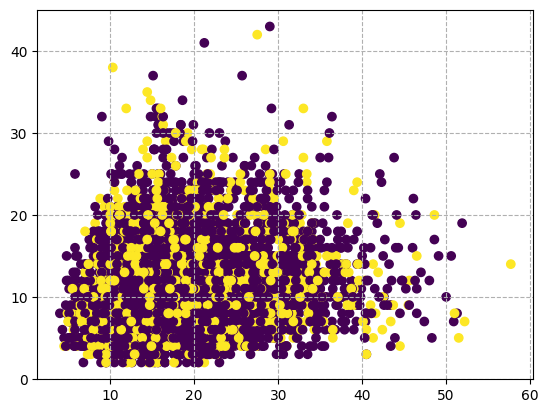

In [227]:
plt.scatter(num_df['years_of_credit_history'], num_df['number_of_open_accounts'], c=num_df['target'])
plt.grid(linestyle='--')
plt.show()

In [228]:
num_df.describe()

,home_ownership,annual_income,years_in_current_job,tax_liens,number_of_open_accounts,years_of_credit_history,maximum_open_credit,number_of_credit_problems,months_since_last_delinquent,bankruptcies,purpose,term,current_loan_amount,current_credit_balance,monthly_debt,credit_score,target
count,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7.500000e+03,7500.000000,7500.000000,7500.000000
mean,1.939067,1.082729e+06,5.540000,0.030133,11.130933,18.317467,9.451537e+05,0.170000,15.815200,0.116933,3.729333,0.740800,1.187318e+07,2.898332e+05,18314.454133,912.121733,0.281733
std,0.956526,9.345581e+05,3.831826,0.271604,4.908924,7.041946,1.602622e+07,0.498598,22.649441,0.346904,2.076435,0.438225,3.192612e+07,3.178714e+05,11926.764673,1502.588014,0.449874
min,0.000000,0.000000e+00,-1.000000,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,0.000000,0.000000
25%,1.000000,5.327268e+05,2.000000,0.000000,8.000000,13.500000,2.792295e+05,0.000000,0.000000,0.000000,3.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,667.000000,0.000000
50%,2.000000,9.891305e+05,6.000000,0.000000,10.000000,17.000000,4.781590e+05,0.000000,0.000000,0.000000,3.000000,1.000000,3.095730e+05,2.093230e+05,16076.500000,722.000000,0.000000
75%,3.000000,1.499974e+06,10.000000,0.000000,14.000000,21.800000,7.935015e+05,0.000000,29.000000,0.000000,3.000000,1.000000,5.198820e+05,3.604062e+05,23818.000000,740.000000,1.000000
max,3.000000,1.014934e+07,10.000000,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,14.000000,1.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


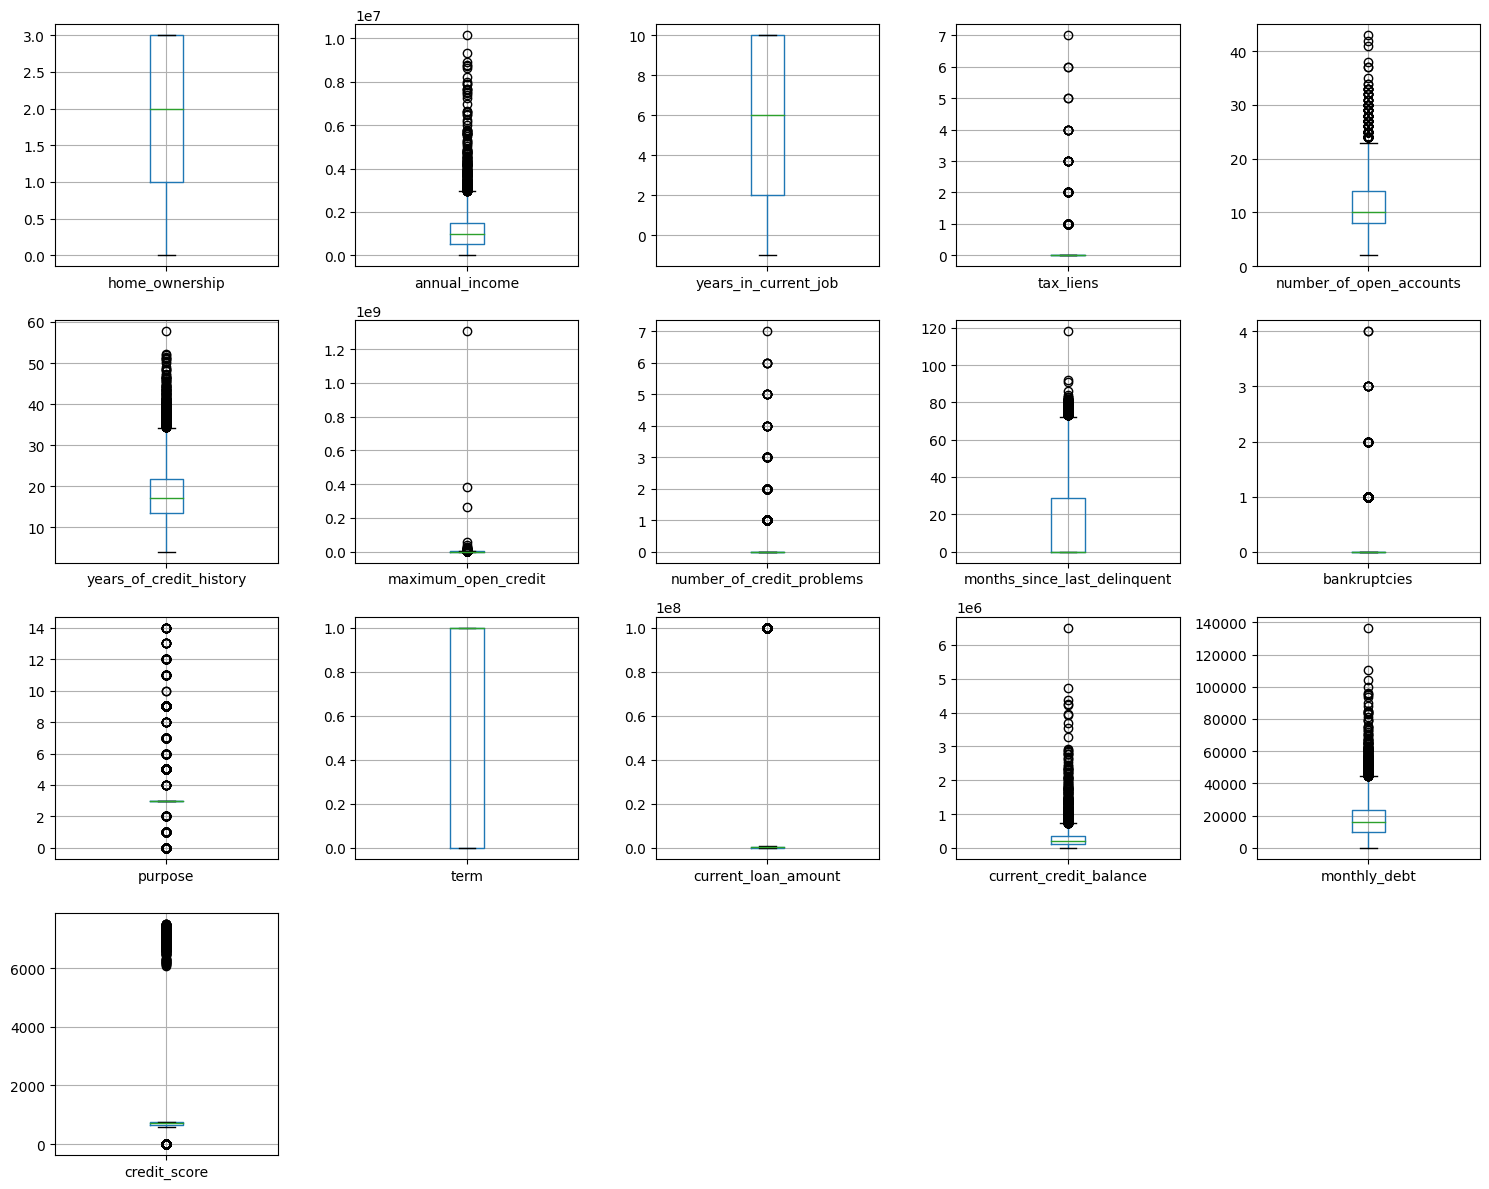

In [229]:
num_variables = len(num_df.columns) - 1

nrows = min(5, (num_variables - 1) // 5 + 1)
ncols = min(5, num_variables)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 3 * nrows))

if nrows > 1:
    axes = axes.flatten()

for i, column in enumerate(num_df.drop('target', axis=1).columns):
    ax = axes[i]
    num_df.boxplot(column, ax=ax)

for i in range(num_variables, nrows * ncols):
    if i < len(axes):
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [230]:
cleaned_df = num_df.copy()
cleaned_df = cleaned_df[cleaned_df['current_loan_amount'] < 0.8e8]
cleaned_df = cleaned_df[cleaned_df['maximum_open_credit'] < 1.2e9]
cleaned_df = cleaned_df[cleaned_df['credit_score'] < 5000]
cleaned_df = cleaned_df[cleaned_df['monthly_debt'] < 13000]

In [231]:
def gini(series): 
    series = series.sort_values().reset_index(drop=True) 
    n = len(series) # Check if series is empty or has only one element 

    if n < 2:
        return None
    
    if series.nunique() == 1:  # Check for zero variance
        return 0
    
    cumsum = series.cumsum() 
    index = range(1, n + 1) 
    
    return (2 * sum(index * series) / (n * sum(series))) - ((n + 1) / n)

In [232]:
df_gini=cleaned_df.apply(gini)
df_gini= df_gini.sort_values(ascending=False).round(2)
df_gini= df_gini.drop(labels=['target'])
df_gini

tax_liens                       0.99
bankruptcies                    0.88
number_of_credit_problems       0.87
months_since_last_delinquent    0.71
years_in_current_job            0.46
maximum_open_credit             0.46
annual_income                   0.45
current_credit_balance          0.41
current_loan_amount             0.33
credit_score                    0.26
purpose                         0.26
number_of_open_accounts         0.25
monthly_debt                    0.23
home_ownership                  0.23
years_of_credit_history         0.22
term                            0.18
dtype: float64

In [233]:
corr_matrix = cleaned_df.select_dtypes(include='number').corr()
corr_pairs = []

min_threshold = 0.05
max_threshold = 1
t_corr = corr_matrix['target'].drop('target', axis=0)
t_corr_significant = t_corr[(abs(t_corr) >= min_threshold) & (abs(t_corr) < max_threshold)]

t_corr_list = [(variable, round(correlation, 2)) for variable, correlation in t_corr_significant.items()]
t_corr_list_sorted = sorted(t_corr_list, key=lambda x: abs(x[1]), reverse=True)
t_corr_list_sorted

[('term', -0.15),
 ('annual_income', -0.14),
 ('home_ownership', 0.12),
 ('credit_score', -0.09),
 ('years_in_current_job', -0.06)]

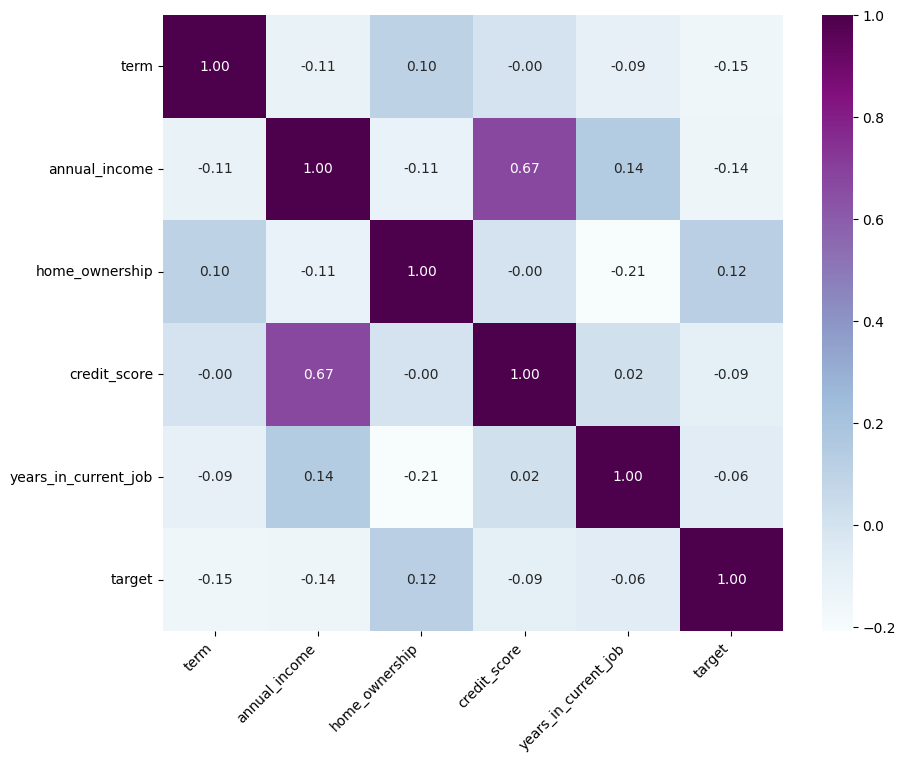

In [234]:
variables = [var for var, _ in t_corr_list_sorted] 

small_df = cleaned_df[variables + ['target']] 
small_corr_matrix = small_df.corr() 

# mask = np.triu(np.ones_like(small_corr_matrix, dtype=bool))

plt.figure(figsize=(10, 8)) 
heatmap = sns.heatmap(small_corr_matrix, annot=True, cmap='BuPu', fmt='.2f')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

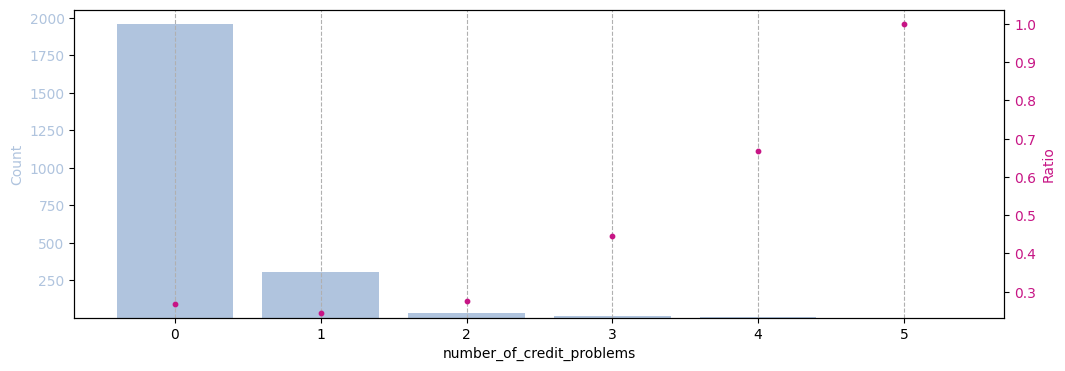

In [235]:
ratios = {}

for column in cleaned_df.columns:
    if column != 'target':
        group_ratios = cleaned_df.groupby(column)['target'].mean()
        ratios[column] = group_ratios

var_ratio_name = 'number_of_credit_problems'

counts_plot = cleaned_df[var_ratio_name].value_counts()
ratios_plot = ratios[var_ratio_name]

filtered_ratios_plot = ratios_plot[ratios_plot > 0.00]

fig, ax1 = plt.subplots(figsize=(12, 4))

color = 'lightsteelblue'
ax1.set_xlabel(var_ratio_name)
ax1.set_ylabel('Count', color=color)
ax1.bar(counts_plot.index, counts_plot.values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

min_count = counts_plot.values.min()
ax1.set_ylim(bottom=min_count - 0.05 * min_count)

ax2 = ax1.twinx()
color = 'mediumvioletred'
ax2.set_ylabel('Ratio', color=color)
ax2.scatter(filtered_ratios_plot.index, filtered_ratios_plot.values, color=color, s=10) # Using scatter plot for filtered ratios
ax2.tick_params(axis='y', labelcolor=color)

min_ratio = filtered_ratios_plot.values.min()
ax2.set_ylim(bottom=min(min_count, min_ratio) - 0.05 * min(min_count, min_ratio))

ax1.grid(axis='x', linestyle="--")
plt.show()


In [236]:
# WOE and IV

binned_df = cleaned_df.copy()

binned_var = 'years_in_current_job'
bins = [float('-inf'), -1, 3, 8, float('inf')]
binned_df[binned_var] = pd.cut(binned_df[binned_var], bins=bins)

val_counts = binned_df.groupby(binned_var)['target'].value_counts()

total_events = val_counts.xs(1, level=1).sum()
total_non_events = val_counts.xs(0, level=1).sum()

woe_iv = val_counts.unstack()

woe_iv['% of dataset'] = (woe_iv.sum(axis=1) / len(binned_df)) * 100

woe_iv['WOE'] = np.log((woe_iv[1] / total_events) / (woe_iv[0] / total_non_events))

sum_class = woe_iv[1] + woe_iv[0]
woe_iv['IV'] = woe_iv['WOE'] * np.log((woe_iv[1] / sum_class) / (woe_iv[0] / sum_class))

woe_iv = woe_iv.round(2)
woe_iv

target,0,1,% of dataset,WOE,IV
years_in_current_job,,,,,
"(-inf, -1.0]",106,64,7.38,0.51,-0.26
"(-1.0, 3.0]",644,230,37.97,-0.01,0.01
"(3.0, 8.0]",458,177,27.58,0.07,-0.06
"(8.0, inf]",483,140,27.06,-0.22,0.27


In [237]:
# Binning 

binned_df = cleaned_df.copy()

binned_var = 'years_in_current_job'
bins = [float('-inf'), -1, 3, 8, float('inf')]
binned_df[binned_var] = pd.cut(binned_df[binned_var], bins=bins)

In [238]:
for column in binned_df.columns:
    if column != 'target':
        if binned_df[column].dtype == 'category' or binned_df[column].nunique() <= 10:
            binned_df[column] = ord.fit_transform(binned_df[[column]])
        else:
            binned_df[column] = rbs.fit_transform(binned_df[[column]]) 
print(binned_df[:5])

    home_ownership  annual_income  years_in_current_job  tax_liens  \
Id                                                                   
3              2.0       0.094814                   2.0        0.0   
4              3.0       0.059934                   2.0        0.0   
8              1.0      -0.880057                   2.0        0.0   
15             3.0       0.147362                   3.0        0.0   
20             1.0       1.120369                   3.0        0.0   

    number_of_open_accounts  years_of_credit_history  maximum_open_credit  \
Id                                                                          
3                       0.0                 0.790698            -0.532557   
4                       1.0                -0.244186             0.144533   
8                       1.8                 0.000000            -0.951130   
15                      0.2                 0.313953            -0.110047   
20                      0.6                 1.2

In [239]:
model_df = binned_df[['target', 'annual_income', 'home_ownership', 'years_in_current_job', 'credit_score']]

In [240]:
# Split dataframe 

X = model_df.drop(['target'], axis=1)
y = model_df['target']

In [241]:
# VIF

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

vif

,VIF Factor,features
0,1.873633,annual_income
1,2.559450,home_ownership
2,2.816247,years_in_current_job
3,2.328007,credit_score


In [242]:
# Oversampling
# import imblearn.over_sampling as imo
# bs = imo.BorderlineSMOTE(sampling_strategy='minority', k_neighbors=4, kind='borderline-2')
# X_resampled, y_resampled = bs.fit_resample(X, y)

# Undersampling
# import imblearn.under_sampling as imu  
# from sklearn.tree import DecisionTreeClassifier
# rfc = RandomForestClassifier(criterion='log_loss', min_samples_split=4, n_estimators=100, max_features='log2', n_jobs=-1)
# iht = imu.InstanceHardnessThreshold(estimator=rfc, cv=10, n_jobs=-1, random_state=42)

# X_resampled, y_resampled = iht.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=1)


round(1e2 * y_test.value_counts()/len(y_test), 2)

target
0    74.67
1    25.33
Name: count, dtype: float64

In [263]:
model = GradientBoostingClassifier()
grid = dict()
grid['n_estimators'] = [3, 5, 7]
grid['learning_rate'] = [0.1, 0.2, 1.0]
grid['subsample'] = [0.1, 0.2, 0.3]
grid['max_depth'] = [1, 3, 5]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
grid_result = grid_search.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.730396 using {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 7, 'subsample': 0.2}
0.729361 (0.002946) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 3, 'subsample': 0.1}
0.729361 (0.002946) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 3, 'subsample': 0.2}
0.729361 (0.002946) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 3, 'subsample': 0.3}
0.729361 (0.002946) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 5, 'subsample': 0.1}
0.729361 (0.002946) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 5, 'subsample': 0.2}
0.729361 (0.002946) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 5, 'subsample': 0.3}
0.729361 (0.002946) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 7, 'subsample': 0.1}
0.729361 (0.002946) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 7, 'subsample': 0.2}
0.729361 (0.002946) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 7, 'su

In [268]:
best_params = grid_result.best_params_
model = GradientBoostingClassifier(**best_params)
model.fit(X_train, y_train)

pred_test = model.predict_proba(X_test)
pred_train = model.predict_proba(X_train)

pred_test, pred_train = pd.DataFrame(pred_test), pd.DataFrame(pred_train)

pred_test = pred_test.drop(0, axis = 1)
pred_train = pred_train.drop(0, axis = 1) 

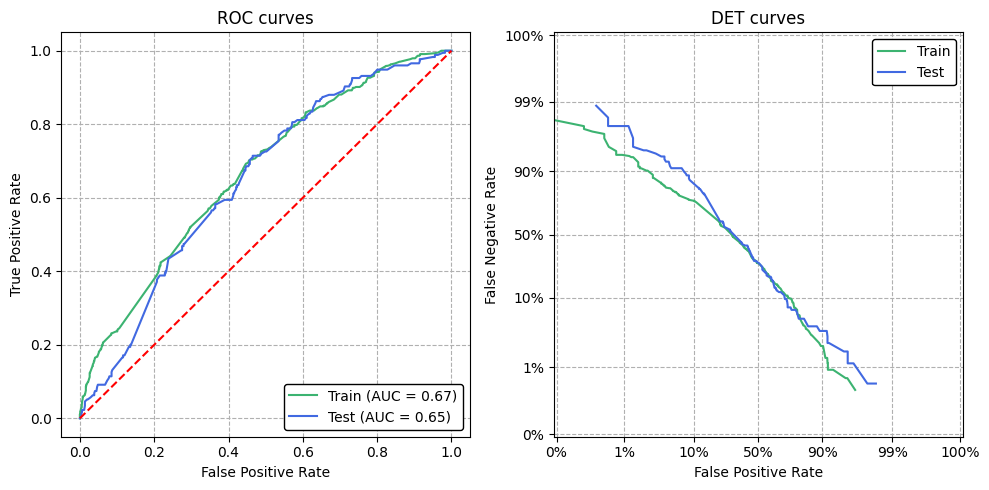

In [269]:
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(10, 5))

def logit(p):
    return np.log(p / (1 - p))

def logistic(x):
    return 1 / (1 + np.exp(-x))

# Function to format the tick labels
def exp_formatter(x, pos):
    return f'{logistic(x):.0%}'

# ROC curve - train data
logit_roc_auc = roc_auc_score(y_train, pred_train)
fpr, tpr, thresholds = roc_curve(y_train, pred_train)
ax_roc.plot(fpr, tpr, color='mediumseagreen', label='Train (AUC = %0.2f)' % logit_roc_auc)

# ROC curve - test data
logit_roc_auc = roc_auc_score(y_test, pred_test)
fpr, tpr, thresholds = roc_curve(y_test, pred_test)
ax_roc.plot(fpr, tpr, color='royalblue', label='Test (AUC = %0.2f)' % logit_roc_auc)

ax_roc.plot([0, 1], [0, 1],'r--')
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.set_title('ROC curves')
ax_roc.legend(loc='lower right', frameon=True, framealpha=1, edgecolor='black')
ax_roc.grid(linestyle="--")

# DET curve - train data
fpr, fnr, thresholds = det_curve(y_train, pred_train)
ax_det.plot(logit(fpr), logit(fnr), color='mediumseagreen', label='Train')

# DET curve - test data
fpr, fnr, thresholds = det_curve(y_test, pred_test)
ax_det.plot(logit(fpr), logit(fnr), color='royalblue', label='Test')

ax_det.set_xlabel('False Positive Rate')
ax_det.set_ylabel('False Negative Rate')
ax_det.set_title('DET curves')
ax_det.legend(loc='best', frameon=True, framealpha=1, edgecolor='black')
ax_det.grid(linestyle="--")

specific_probs = np.array([0.001, 0.01, 0.1, 0.5, 0.9, 0.99, 0.999])  
tick_logit_values = logit(specific_probs)  
tick_labels = ['0%', '1%', '10%', '50%', '90%', '99%', '100%']

ax_det.set_xticks(tick_logit_values)
ax_det.set_xticklabels(tick_labels)
ax_det.set_yticks(tick_logit_values)
ax_det.set_yticklabels(tick_labels)

ax_det.set_xlim([-7, 7])
ax_det.set_ylim([-7, 7])

ax_det.xaxis.set_major_formatter(FuncFormatter(exp_formatter))
ax_det.yaxis.set_major_formatter(FuncFormatter(exp_formatter))

plt.tight_layout()
plt.show()

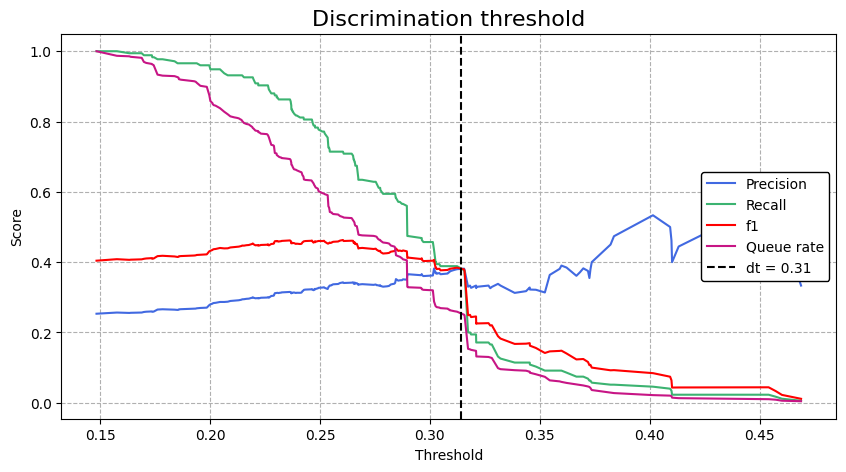

In [272]:
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_test)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
queue_rates = [np.mean(pred_test >= threshold) for threshold in thresholds]

diff_prec_recall = np.abs(precisions - recalls)
min_diff_index = np.argmin(diff_prec_recall[:-1])  
disc_threshold = thresholds[min_diff_index]

plt.figure(figsize=(10,5))
plt.plot(thresholds, precisions[:-1], 'royalblue', linestyle = '-', label='Precision')
plt.plot(thresholds, recalls[:-1], 'mediumseagreen', linestyle = '-', label='Recall')
plt.plot(thresholds, f1_scores[:-1], 'red', linestyle = '-', label='f1')
plt.plot(thresholds, queue_rates, 'mediumvioletred', linestyle = '-', label='Queue rate')
plt.axvline(x=disc_threshold, color='k', linestyle='--', label=f'dt = {disc_threshold:.2f}')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Discrimination threshold', size=16)
plt.legend(loc='right', frameon=True, framealpha=1, edgecolor='black')
plt.grid(linestyle="--")
plt.show()

In [279]:
pred_test_binary = (pred_test >= disc_threshold).astype(int)
print(round(pd.DataFrame(confusion_matrix(y_test, pred_test_binary)/len(y_test)*1e2)))

      0     1
0  59.0  16.0
1  16.0  10.0


In [280]:
print(classification_report(y_test, pred_test_binary), f"threshold: {disc_threshold.round(2)}")

              precision    recall  f1-score   support

           0       0.79      0.79      0.79       516
           1       0.38      0.38      0.38       175

    accuracy                           0.69       691
   macro avg       0.59      0.59      0.59       691
weighted avg       0.69      0.69      0.69       691
 threshold: 0.31


In [281]:
predtest_df = pred_test.rename({1: 'prob_default'}, axis=1)
predtrain_df = pred_train.rename({1: 'prob_default'}, axis=1)
predtest_df['class'] = pred_test_binary
predtest_df

,prob_default,class
0,0.289526,0
1,0.173551,0
2,0.229228,0
3,0.366637,1
4,0.229228,0
...,...,...
686,0.328172,1
687,0.185258,0
688,0.186839,0
689,0.249035,0


In [282]:
ks_x = predtest_df['prob_default'][predtest_df['class']==0]
ks_y = predtest_df['prob_default'][predtest_df['class']==1]

ks_2samp(ks_x, ks_y)

KstestResult(statistic=1.0, pvalue=2.9572370674374335e-169, statistic_location=0.31234523200011083, statistic_sign=1)

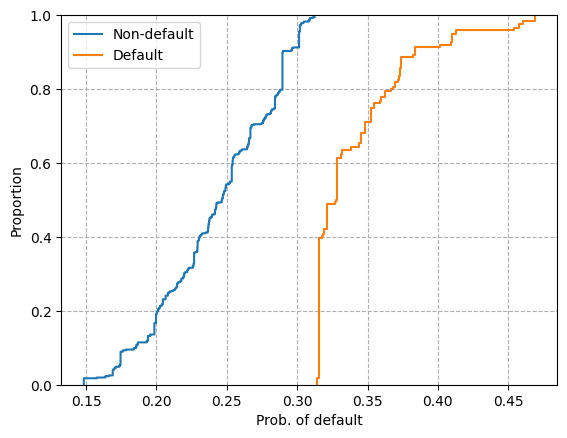

In [283]:
ks_df = pd.DataFrame({'Non-default': ks_x, 'Default': ks_y})

ax = sns.ecdfplot(ks_df)
ax.set(xlabel='Prob. of default')
ax.grid(linestyle="--")

In [284]:
percentile_train = np.percentile(predtrain_df['prob_default'], np.arange(0,101,10))
percentile_test = np.percentile(predtest_df['prob_default'], np.arange(0,101,10))

def count_values_in_percentiles(df, percentiles):
    counts = []
    # Adjust range to include the last percentile
    for i in range(len(percentiles) - 1):
        count = df[(df['prob_default'] > percentiles[i]) & (df['prob_default'] <= percentiles[i+1])].shape[0]
        counts.append(count)
    return counts

train_counts = count_values_in_percentiles(predtrain_df, percentile_train)
test_counts = count_values_in_percentiles(predtest_df, percentile_test)

psi_df = pd.DataFrame([percentile_train, percentile_test, train_counts, test_counts]).T
psi_df.columns = ['percentile_train', 'percentile_test', 'train_counts', 'test_counts']

psi_df = psi_df.drop(index=10)

psi_df['train_pct'] = psi_df['train_counts']/np.sum(psi_df['train_counts']) * 100
psi_df['test_pct'] = psi_df['test_counts']/np.sum(psi_df['test_counts']) * 100
psi_df = psi_df.round(2)
psi_df

,percentile_train,percentile_test,train_counts,test_counts,train_pct,test_pct
0,0.15,0.15,164.0,61.0,10.25,8.94
1,0.20,0.20,148.0,71.0,9.25,10.41
2,0.22,0.21,169.0,67.0,10.56,9.82
3,0.24,0.23,196.0,71.0,12.25,10.41
4,0.25,0.25,118.0,79.0,7.38,11.58
5,0.27,0.27,228.0,105.0,14.25,15.40
6,0.29,0.29,100.0,29.0,6.25,4.25
7,0.30,0.30,245.0,93.0,15.31,13.64
8,0.32,0.32,72.0,38.0,4.50,5.57
9,0.33,0.33,160.0,68.0,10.00,9.97


In [285]:
psi_val = np.sum((psi_df['train_pct'] - psi_df['test_pct']) * np.log(psi_df['train_pct'] / psi_df['test_pct']))
psi_val.round(2)

3.84

In [286]:
jaccard_score(y_test, pred_test_binary).round(2)

0.24

In [287]:
class_likelihood_ratios(y_test, pred_test_binary)

(1.812424639580603, 0.7824219024219025)